In [39]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_profiling
from time import time
from random import random
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import RUSBoostClassifier
from tffm import TFFMClassifier
%matplotlib inline

In [3]:
# data preprocessing
data = pd.read_csv(r'./data_cleared.csv')
data.drop('Unnamed: 0', axis = 1,inplace = True)

In [4]:
data.head()

,click,brows_name,brows_vendor,connect,county_name,device,screen_orient,hard_family,hard_vendor,mobile_operator,platform,plat_name,plat_vendor,plat_version
0,0.0,Chrome Mobile,Google,xdsl,ukr,SmartPhone,False,Chrome Mobile,Samsung,unknown,mobile,Android,Google,8.0
1,0.0,Samsung Browser,Samsung,cable,ukr,SmartPhone,True,Samsung Browser,Samsung,unknown,mobile,Android,Google,8.0
2,0.0,Chrome Mobile,Google,xdsl,bel,SmartPhone,False,Chrome Mobile,unknown,unknown,mobile,Android,Google,6.0
3,0.0,Chrome Mobile,Google,broadband,bel,SmartPhone,False,Chrome Mobile,Samsung,unknown,mobile,Android,Google,8.0
4,0.0,Chrome Mobile,Google,broadband,bel,SmartPhone,False,Chrome Mobile,ALCATEL ONE TOUCH,unknown,mobile,Android,Google,4.4.2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475256 entries, 0 to 475255
Data columns (total 14 columns):
click              475256 non-null float64
brows_name         475256 non-null object
brows_vendor       475256 non-null object
connect            475256 non-null object
county_name        475256 non-null object
device             475256 non-null object
screen_orient      475256 non-null bool
hard_family        475256 non-null object
hard_vendor        475256 non-null object
mobile_operator    475256 non-null object
platform           475256 non-null object
plat_name          475256 non-null object
plat_vendor        475256 non-null object
plat_version       475256 non-null object
dtypes: bool(1), float64(1), object(12)
memory usage: 47.6+ MB


In [6]:
pandas_profiling.ProfileReport(data)

Number of variables,14
Number of observations,475256
Total Missing (%),0.0%
Total size in memory,47.6 MiB
Average record size in memory,105.0 B
Numeric,0
Categorical,12
Boolean,2
Date,0
Text (Unique),0
Rejected,0


Reduce dataset to 100000 rows

In [7]:
data_reduced = data.sample(100000, random_state = 33)

In [22]:
Counter(data_reduced['click'])

Counter({0.0: 92632, 1.0: 7368})

In [8]:
# features & labels
labels = data_reduced['click']
features = data_reduced.drop('click', axis = 1)

In [9]:
# create the dictionary of unique attributes' lists
unique_attr = {}
for attr in features.columns:
    unique_attr[attr] = features[attr].unique().tolist()
unique_attr

{'brows_name': ['Chrome Mobile',
  'Kindle-Silk',
  'Samsung Browser',
  'Mobile Safari',
  'Android',
  'Chrome for iOS',
  'Firefox for Mobile',
  'Firefox for iOS',
  'Sleipnir - WebKit Engine',
  'UCBrowser for Android',
  'Edge Mobile',
  'Aloha Browser for iOS',
  'Facebook for Android',
  'Firefox',
  'Puffin for Android',
  'Smooz for iOS',
  'Instagram for Android',
  'Edge',
  'Facebook for iOS',
  'Aloha Browser for Android',
  'Firefox Focus for Android',
  'Internet Explorer',
  'Edge for iOS',
  'Instagram for iOS',
  'Yahoo! browser for Android',
  'Opera Mini for iOS',
  'BlackBerry Browser',
  'MIUI Browser',
  'PS Vita Browser',
  'Chrome',
  'Opera Mobile',
  'NTENT',
  'Safari',
  'UCBrowser for iPhone',
  'Baidu Browser',
  'Seznam For Android',
  'Opera Desktop',
  'Internet Explorer (Mobile in desktop mode)',
  'iLunascape for iOS',
  'Edge for Android',
  'LINE App',
  'Pinterest for Android',
  'CM Mobile Browser',
  'Puffin for iOS',
  'Quick Browser for Andro

In [10]:
# features encoding
encoder = preprocessing.OneHotEncoder(categories=[unique_attr[i] for i in unique_attr], sparse = False, handle_unknown='ignore')
encoder

OneHotEncoder(categorical_features=None,
       categories=[['Chrome Mobile', 'Kindle-Silk', 'Samsung Browser', 'Mobile Safari', 'Android', 'Chrome for iOS', 'Firefox for Mobile', 'Firefox for iOS', 'Sleipnir - WebKit Engine', 'UCBrowser for Android', 'Edge Mobile', 'Aloha Browser for iOS', 'Facebook for Android', 'Firefox', 'Puffin for Android',... '10.0.3', '10.9.5', '3.2', '8.4', '10.10.5', '1.2', '1.5', '3.68', '4.4.1', '6.1.2', '8.3', '3.0']],
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=False)

In [11]:
# Concatenating
features['CONCAT'] = features.values.tolist()
features['CONCAT'].head()

253991    [Chrome Mobile, Google, mobile, ukr, SmartPhon...
191421    [Kindle-Silk, Amazon, broadband, ukr, EReader,...
268725    [Chrome Mobile, Google, cable, bel, SmartPhone...
461544    [Chrome Mobile, Google, mobile, ukr, SmartPhon...
383331    [Chrome Mobile, Google, broadband, bel, SmartP...
Name: CONCAT, dtype: object

In [12]:
# Encoding
t0 = time()
features['ENCODED'] = [encoder.fit_transform([i]).flatten() for i in features['CONCAT']]
print ("time on encoding:", round(time()-t0, 3), "s")

time on encoding: 65.179 s


In [13]:
# create the array with feature vectors
features_list = [list(i) for i in features['ENCODED']]
features_list_array = np.array(features_list)

In [14]:
# create the array with label vector 
labels_list_array = np.array(labels.tolist())

In [15]:
# cross-validation
X_train, X_test, y_train, y_test = train_test_split(features_list_array, labels_list_array, random_state=42, test_size=0.3)

In [17]:
# test on LogisticRegression & RandomForestClassifier & DecisionTreeClassifier
for model in [
                LogisticRegression(), 
                RandomForestClassifier(n_jobs=-1, n_estimators=200),
                tree.DecisionTreeClassifier()
            ]:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    print('model: {}'.format(model.__str__()))
    print('Accuracy is ', accuracy_score(y_test, predictions)*100)
    print('Sensivity score is ', sensitivity_score(y_test, predictions))
    print('Specificity_score is ', specificity_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test,predictions))
    print()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy is  92.50666666666667
Sensivity score is  0.0
Specificity_score is  1.0
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.00      0.00      0.00      2248

   micro avg       0.93      0.93      0.93     30000
   macro avg       0.46      0.50      0.48     30000
weighted avg       0.86      0.93      0.89     30000

[[27752     0]
 [ 2248     0]]



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy is  92.30000000000001
Sensivity score is  0.008896797153024912
Specificity_score is  0.9970452579994235
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.20      0.01      0.02      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.56      0.50      0.49     30000
weighted avg       0.87      0.92      0.89     30000

[[27670    82]
 [ 2228    20]]

model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max

TFFM

In [18]:
# Invert train/test datasets into sparse matrix
X_train_sparse = sp.csr_matrix(X_train)
X_test_sparse = sp.csr_matrix(X_test)

In [19]:
# Fitting parameters with input_type='sparse' 
for order in [2, 3]:
    for rank in [10,30,50]:
        model = TFFMClassifier(
        order=order, 
        rank=rank, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
        n_epochs=50, 
        batch_size=1024,
        init_std=0.001,
        reg=0.01,
        input_type='sparse',
        seed=42)
        model.fit(X_train_sparse, y_train, show_progress=True)
        predictions = model.predict(X_test_sparse)
        print('[order={}] [rank={}] accuracy: {}'.format(order,rank, accuracy_score(y_test, predictions)))
        print('Accuracy is ', accuracy_score(y_test, predictions)*100)
        print('Sensivity score is ', sensitivity_score(y_test, predictions))
        print('Specificity_score is ', specificity_score(y_test, predictions))
        print(classification_report(y_test, predictions))
        print(confusion_matrix(y_test,predictions))

        print()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


100%|██████████| 50/50 [00:05<00:00, 11.03epoch/s]


[order=2] [rank=10] accuracy: 0.9246333333333333
Accuracy is  92.46333333333332
Sensivity score is  0.0035587188612099642
Specificity_score is  0.9992432977803402
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.28      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.60      0.50      0.48     30000
weighted avg       0.88      0.92      0.89     30000

[[27731    21]
 [ 2240     8]]



100%|██████████| 50/50 [00:06<00:00,  8.58epoch/s]


[order=2] [rank=30] accuracy: 0.9244
Accuracy is  92.44
Sensivity score is  0.0035587188612099642
Specificity_score is  0.9989910637071202
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.22      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.57      0.50      0.48     30000
weighted avg       0.87      0.92      0.89     30000

[[27724    28]
 [ 2240     8]]



100%|██████████| 50/50 [00:08<00:00,  6.06epoch/s]


[order=2] [rank=50] accuracy: 0.9244
Accuracy is  92.44
Sensivity score is  0.004448398576512456
Specificity_score is  0.9989189968290574
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.25      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.59      0.50      0.48     30000
weighted avg       0.87      0.92      0.89     30000

[[27722    30]
 [ 2238    10]]



100%|██████████| 50/50 [00:06<00:00,  7.71epoch/s]


[order=3] [rank=10] accuracy: 0.9246
Accuracy is  92.46
Sensivity score is  0.0026690391459074734
Specificity_score is  0.9992793312193716
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.23      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.58      0.50      0.48     30000
weighted avg       0.87      0.92      0.89     30000

[[27732    20]
 [ 2242     6]]



100%|██████████| 50/50 [00:10<00:00,  5.64epoch/s]


[order=3] [rank=30] accuracy: 0.9243666666666667
Accuracy is  92.43666666666667
Sensivity score is  0.00400355871886121
Specificity_score is  0.9989189968290574
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.23      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.58      0.50      0.48     30000
weighted avg       0.87      0.92      0.89     30000

[[27722    30]
 [ 2239     9]]



100%|██████████| 50/50 [00:13<00:00,  4.42epoch/s]

[order=3] [rank=50] accuracy: 0.9243666666666667
Accuracy is  92.43666666666667
Sensivity score is  0.00400355871886121
Specificity_score is  0.9989189968290574
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.23      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.58      0.50      0.48     30000
weighted avg       0.87      0.92      0.89     30000

[[27722    30]
 [ 2239     9]]



In [23]:
# Fitting parameters with input_type='dense' 
for order in [2, 3]:
    for rank in [10,30,50]:
        model = TFFMClassifier(
        order=order, 
        rank=rank, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
        n_epochs=50, 
        batch_size=1024,
        init_std=0.001,
        reg=0.01,
        input_type='dense',
        seed=42)
        model.fit(X_train, y_train, show_progress=True)
        predictions = model.predict(X_test)
        print('[order={}] [rank={}] accuracy: {}'.format(order,rank, accuracy_score(y_test, predictions)))
        print('Accuracy is ', accuracy_score(y_test, predictions)*100)
        print('Sensivity score is ', sensitivity_score(y_test, predictions))
        print('Specificity_score is ', specificity_score(y_test, predictions))
        print(classification_report(y_test, predictions))
        print(confusion_matrix(y_test,predictions))
        print()

100%|██████████| 50/50 [00:19<00:00,  2.61epoch/s]


[order=2] [rank=10] accuracy: 0.9246333333333333
Accuracy is  92.46333333333332
Sensivity score is  0.0035587188612099642
Specificity_score is  0.9992432977803402
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.28      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.60      0.50      0.48     30000
weighted avg       0.88      0.92      0.89     30000

[[27731    21]
 [ 2240     8]]



100%|██████████| 50/50 [00:22<00:00,  2.20epoch/s]


[order=2] [rank=30] accuracy: 0.9244
Accuracy is  92.44
Sensivity score is  0.0035587188612099642
Specificity_score is  0.9989910637071202
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.22      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.57      0.50      0.48     30000
weighted avg       0.87      0.92      0.89     30000

[[27724    28]
 [ 2240     8]]



100%|██████████| 50/50 [00:25<00:00,  1.85epoch/s]


[order=2] [rank=50] accuracy: 0.9244
Accuracy is  92.44
Sensivity score is  0.004448398576512456
Specificity_score is  0.9989189968290574
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.25      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.59      0.50      0.48     30000
weighted avg       0.87      0.92      0.89     30000

[[27722    30]
 [ 2238    10]]



100%|██████████| 50/50 [00:32<00:00,  1.42epoch/s]


[order=3] [rank=10] accuracy: 0.9246
Accuracy is  92.46
Sensivity score is  0.0026690391459074734
Specificity_score is  0.9992793312193716
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.23      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.58      0.50      0.48     30000
weighted avg       0.87      0.92      0.89     30000

[[27732    20]
 [ 2242     6]]



100%|██████████| 50/50 [00:38<00:00,  1.24epoch/s]


[order=3] [rank=30] accuracy: 0.9243666666666667
Accuracy is  92.43666666666667
Sensivity score is  0.00400355871886121
Specificity_score is  0.9989189968290574
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.23      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.58      0.50      0.48     30000
weighted avg       0.87      0.92      0.89     30000

[[27722    30]
 [ 2239     9]]



100%|██████████| 50/50 [00:44<00:00,  1.16epoch/s]


[order=3] [rank=50] accuracy: 0.9243666666666667
Accuracy is  92.43666666666667
Sensivity score is  0.00400355871886121
Specificity_score is  0.9989189968290574
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.23      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.58      0.50      0.48     30000
weighted avg       0.87      0.92      0.89     30000

[[27722    30]
 [ 2239     9]]



Optimizers

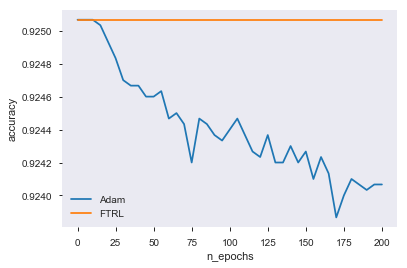

In [24]:
# there 2 optimizers will be used: AdamOptimizer and FtrlOptimizer
for optim, title in [(tf.train.AdamOptimizer(learning_rate=0.001), 'Adam'), 
              (tf.train.FtrlOptimizer(0.01, l1_regularization_strength=0.01), 'FTRL')]:
    acc = []
    model = TFFMClassifier(
        order=2, 
        rank=10, 
        optimizer=optim,
        batch_size=1024,
        init_std=0.001,
        reg=0.1,
        input_type='sparse',
    )
    n_epochs = 5
    anchor_epochs = range(0, 200+1, n_epochs)
    for _ in anchor_epochs:
        # score result every 5 epochs
        model.fit(X_train_sparse, y_train, n_epochs=n_epochs)
        predictions = model.predict(X_test_sparse)
        acc.append(accuracy_score(y_test, predictions))
    plt.plot(anchor_epochs, acc, label=title)
    model.destroy()
plt.xlabel('n_epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

In [25]:
# CPU
model = TFFMClassifier(
    order=2,
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
    n_epochs=100, 
    batch_size=-1,
    init_std=0.001,
    reg=0.001,
    input_type='sparse',
    session_config=tf.ConfigProto(log_device_placement=True, device_count = {'GPU': 0}),
    seed=42
)
print('CPU only / sparse data')
model.fit(X_train_sparse, y_train, show_progress=True)
predictions = model.predict(X_test_sparse)
print('accuracy: {}'.format(accuracy_score(y_test, predictions)))
model.destroy()

CPU only / sparse data


100%|██████████| 100/100 [00:08<00:00, 11.69epoch/s]

accuracy: 0.9246333333333333


In [26]:
# GPU
model = TFFMClassifier(
    order=2,
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01), 
    n_epochs=100, 
    batch_size=-1,
    init_std=0.001,
    reg=0.001,
    input_type='sparse',
    session_config=tf.ConfigProto(log_device_placement=True),
    seed=42
)
print('GPU / sparse data')
model.fit(X_train_sparse, y_train, show_progress=True)
predictions = model.predict(X_test_sparse)
print('accuracy: {}'.format(accuracy_score(y_test, predictions)))
model.destroy()

GPU / sparse data


100%|██████████| 100/100 [00:07<00:00, 13.27epoch/s]

accuracy: 0.9246333333333333


Weighted Loss Function

In [27]:
print('Classes balance: {:.03f} / {:.03f}'.format(np.mean(labels_list_array==0), 
                                                  np.mean(labels_list_array==1)))

Classes balance: 0.926 / 0.074


In [28]:
# sample_weight='balanced'
order = 2
model = TFFMClassifier(
    order=order,
    sample_weight='balanced',
    rank=10, 
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
    n_epochs=50, 
    batch_size=1024,
    init_std=0.001,
    reg=0.01,
    input_type='sparse',
    seed=42
)
model.fit(X_train_sparse, y_train, show_progress=True)
predictions = model.predict(X_test_sparse)
print('[order={}] [rank={}] accuracy: {}'.format(order,rank, accuracy_score(y_test, predictions)))
print('Accuracy is ', accuracy_score(y_test, predictions)*100)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test,predictions))
print('Sensivity score is ', sensitivity_score(y_test, predictions))
print('Specificity_score is ', specificity_score(y_test, predictions))
model.destroy()

100%|██████████| 50/50 [00:04<00:00, 10.60epoch/s]


[order=2] [rank=50] accuracy: 0.6408666666666667
Accuracy is  64.08666666666667
              precision    recall  f1-score   support

         0.0       0.98      0.62      0.76     27752
         1.0       0.16      0.86      0.26      2248

   micro avg       0.64      0.64      0.64     30000
   macro avg       0.57      0.74      0.51     30000
weighted avg       0.92      0.64      0.73     30000

[[17295 10457]
 [  317  1931]]
Sensivity score is  0.8589857651245552
Specificity_score is  0.6231983280484289


In [29]:
# weight - optional
pos_class_weight = list(map(float,range(1, 5)))
for weight in pos_class_weight:
    order = 2
    model = TFFMClassifier(
        order=order,
        pos_class_weight=weight,
        rank=10, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
        n_epochs=40, 
        batch_size=1024,
        init_std=0.001,
        reg=0.01,
        input_type='sparse',
        seed=42
    )
    model.fit(X_train_sparse, y_train, show_progress=True)
    predictions = model.predict(X_test_sparse)
    print('[order={}] [rank={}] accuracy: {}'.format(order,rank, accuracy_score(y_test, predictions)))
    print('Accuracy is ', accuracy_score(y_test, predictions)*100)
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test,predictions))
    print('Sensivity score is ', sensitivity_score(y_test, predictions))
    print('Specificity_score is ', specificity_score(y_test, predictions))
    model.destroy()

100%|██████████| 40/40 [00:03<00:00, 10.88epoch/s]


[order=2] [rank=50] accuracy: 0.9247
Accuracy is  92.47
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.30      0.00      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.61      0.50      0.48     30000
weighted avg       0.88      0.92      0.89     30000

[[27733    19]
 [ 2240     8]]
Sensivity score is  0.0035587188612099642
Specificity_score is  0.999315364658403


100%|██████████| 40/40 [00:03<00:00, 10.52epoch/s]


[order=2] [rank=50] accuracy: 0.9238
Accuracy is  92.38
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     27752
         1.0       0.23      0.01      0.01      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.58      0.50      0.49     30000
weighted avg       0.87      0.92      0.89     30000

[[27698    54]
 [ 2232    16]]
Sensivity score is  0.0071174377224199285
Specificity_score is  0.9980541942923032


100%|██████████| 40/40 [00:04<00:00,  9.33epoch/s]


[order=2] [rank=50] accuracy: 0.9211666666666667
Accuracy is  92.11666666666667
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     27752
         1.0       0.19      0.02      0.03      2248

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.56      0.51      0.49     30000
weighted avg       0.87      0.92      0.89     30000

[[27600   152]
 [ 2213    35]]
Sensivity score is  0.015569395017793594
Specificity_score is  0.994522917267224


100%|██████████| 40/40 [00:04<00:00,  9.04epoch/s]


[order=2] [rank=50] accuracy: 0.9056
Accuracy is  90.56
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     27752
         1.0       0.19      0.08      0.11      2248

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.56      0.53      0.53     30000
weighted avg       0.87      0.91      0.89     30000

[[26989   763]
 [ 2069   179]]
Sensivity score is  0.07962633451957295
Specificity_score is  0.9725064860190257


Different regularization strategies

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


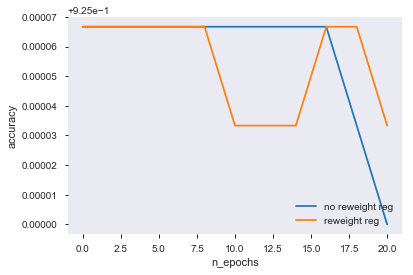

In [30]:
for use_reweight, title in [(False, 'no reweight reg'), (True, 'reweight reg')]:
    acc = []
    model = TFFMClassifier(
        order=2, 
        rank=10, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
        batch_size=1024,
        init_std=0.001,
        reg=1.0,
        input_type='sparse',
        reweight_reg = use_reweight
    )
    n_epochs = 2
    anchor_epochs = range(0, 20+1, n_epochs)
    for _ in anchor_epochs:
        # score result every 5 epochs
        model.fit(X_train_sparse, y_train, n_epochs=n_epochs)
        predictions = model.predict(X_test_sparse)
        acc.append(accuracy_score(y_test, predictions))
    plt.plot(anchor_epochs, acc, label=title)
    model.destroy()
plt.xlabel('n_epochs')
plt.ylabel('accuracy')
plt.legend(loc=4)
plt.grid()

Parameters
    ----------
    order : int, default: 2
        Order of corresponding polynomial model.
        All interaction from bias and linear to order will be included.
    rank : int, default: 5
        Number of factors in low-rank appoximation.
        This value is shared across different orders of interaction.
    input_type : str, 'dense' or 'sparse', default: 'dense'
        Type of input data. Only numpy.array allowed for 'dense' and
        scipy.sparse.csr_matrix for 'sparse'. This affects construction of
        computational graph and cannot be changed during training/testing.
    loss_function : function: (tf.Op, tf.Op) -> tf.Op, default: None
        Loss function.
        Take 2 tf.Ops: outputs and targets and should return tf.Op of loss
        See examples: .utils.loss_mse, .utils.loss_logistic
    optimizer : tf.train.Optimizer, default: AdamOptimizer(learning_rate=0.01)
        Optimization method used for training
    reg : float, default: 0
        Strength of L2 regularization
    use_diag : bool, default: False
        Use diagonal elements of weights matrix or not.
        In the other words, should terms like x^2 be included.
        Ofter reffered as a "Polynomial Network".
        Default value (False) corresponds to FM.
    reweight_reg : bool, default: False
        Use frequency of features as weights for regularization or not.
        Should be usefull for very sparse data and/or small batches
    init_std : float, default: 0.01
        Amplitude of random initialization
    seed : int or None, default: None
        Random seed used at graph creating time

IMBLEARN LIFEHACK

In [32]:
# Apply nearmiss (version = 1) for balancing
t0 = time()
nm1 = NearMiss(version=1)
X_resampled, y_resampled = nm1.fit_resample(features_list_array, labels_list_array)
print(sorted(Counter(y_resampled).items()))
print ("time on sampling:", round(time()-t0, 3), "s")

[(0.0, 7368), (1.0, 7368)]
time on sampling: 180.306 s


In [33]:
# cross-validation
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=35, test_size=0.2)

In [40]:
clfs = [
        ['RandomForestClassifier', RandomForestClassifier()],
        ['ExtraTreesClassifier', ExtraTreesClassifier()],
        ['MLPClassifier', MLPClassifier()],
        ['RUSBoostClassifier', RUSBoostClassifier()],
        ['TFFMClassifier', TFFMClassifier()]
       ]
t = time()
for name, clf in clfs:
    t0 = time()
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    print('Accuracy is ', accuracy_score(y_test, prediction)*100)
    print(classification_report_imbalanced(y_test, prediction, target_names=['0', '1']))
    print('Sensivity score is ', sensitivity_score(y_test, prediction))
    print('Specificity_score is ', specificity_score(y_test, prediction))
    print ("Time on model's work:", round(time()-t0, 3), "s")
    print('='*100)
print ("TOTAL TIME SPENT: ", round(time()-t, 3), "s")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.75      0.57      0.65      1466
         1.0       0.66      0.81      0.73      1482

   micro avg       0.69      0.69      0.69      2948
   macro avg       0.70      0.69      0.69      2948
weighted avg       0.70      0.69      0.69      2948

[[ 838  628]
 [ 280 1202]]
Accuracy is  69.19945725915875
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.57      0.81      0.65      0.68      0.45      1466
          1       0.66      0.81      0.57      0.73      0.68      0.47      1482

avg / total       0.70      0.69      0.69      0.69      0.68      0.46      2948

Sensivity score is  0.8110661268556005
Specificity_score is  0.5716234652114598
Time on model's work: 0.397 s


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier
              precision    recall  f1-score   support

         0.0       0.73      0.59      0.65      1466
         1.0       0.66      0.79      0.72      1482

   micro avg       0.69      0.69      0.69      2948
   macro avg       0.69      0.69      0.68      2948
weighted avg       0.69      0.69      0.68      2948

[[ 861  605]
 [ 316 1166]]
Accuracy is  68.7584803256445
                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.59      0.79      0.65      0.68      0.45      1466
          1       0.66      0.79      0.59      0.72      0.68      0.47      1482

avg / total       0.69      0.69      0.69      0.68      0.68      0.46      2948

Sensivity score is  0.786774628879892
Specificity_score is  0.58731241473397
Time on model's work: 0.493 s
MLPClassifier
              precision    recall  f1-score   support

         0.0       0.73      0.60      0.66      1466
         1.0       0.66      0